In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import date
import datetime
import sys 
import os
from ipynb.fs.full.FXpricelist import full_df
import seaborn as sns

In [2]:
def get_raw_data(name,years):
    #pull data from yfinance
    start_date = datetime.datetime.now() - datetime.timedelta(days=365*years)
    end_date = date.today()
    ticker = yf.Ticker(name)
    df = ticker.history(interval="1d",start=start_date,end=end_date)

    #clean dataframe
    try:
        df = df.drop(["Volume", "Dividends","Stock Splits"], axis=1)
    except:
        pass
    cols = df.columns[df.dtypes.eq(object)]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=0)
    return(df)

def calc_macd(df):
    #calculate macds
    df["k"] = df["Close"].ewm(span=12, adjust=False, min_periods=12).mean()
    df["d"] = df["Close"].ewm(span=26, adjust=False, min_periods=12).mean()

    # Get the 9-Day EMA of the MACD for the Trigger line
    df["macd"] = df["k"] - df["d"]  #ema diff
    df["macd_s"] = df["macd"].ewm(span=9, adjust=False, min_periods=9).mean() #ema of ema diff
    df["macd_h"] =  df["macd"] - df["macd_s"]
    return(df)

def calc_macd_cols(series): 
    df = series.to_frame()
    df.columns = ["Close"]
    #calculate macds
    df["k"] = df.ewm(span=12, adjust=False, min_periods=12).mean()
    df["d"] = series.ewm(span=26, adjust=False, min_periods=12).mean()

    # Get the 9-Day EMA of the MACD for the Trigger line
    df["macd"] = df["k"] - df["d"]  #ema diff
    df["macd_s"] = df["macd"].ewm(span=9, adjust=False, min_periods=9).mean() #ema of ema diff
    df["macd_h"] =  df["macd"] - df["macd_s"]
    return(df["macd_h"])

def chart_macd(df):
    # Construct a 2 x 1 Plotly figure
    fig = make_subplots(rows=2, cols=1)

    # Colorize the histogram values
    colors = np.where(df['macd_h'] < 0, '#000', '#ff9900')

    fig.append_trace(
        go.Candlestick(x=df.index,
                    open=df['Open'],
                    high=df['High'],
                    low=df['Low'],
                    close=df['Close'],
                    name = "candles",
        ), row = 1, col = 1)

    fig.append_trace(
        go.Scatter(
            x=df.index,
            y=df["macd_s"],
            name = "macd_signal"
        ), row = 2, col = 1)

    fig.append_trace(
        go.Scatter(
            x=df.index,
            y=df["macd"],
            name = "macd"
        ), row = 2, col = 1)

    fig.append_trace(
        go.Bar(
            x=df.index,
            y=df['macd_h'],
            name='spread',
            marker_color = colors
        ), row=2, col=1
    )

    # Make it pretty
    layout = go.Layout(
        plot_bgcolor='#211f1f',
        # Font Families
        font_family='Monospace',
        font_color='#000000',
        font_size=12,
        width=800,
        height=800,
        autosize=False,
        title=adj_name,
        xaxis=dict(
            rangeslider=dict(
                visible=False
            )
        )
    )

    fig.update_layout(layout)

    #fig.update_yaxes(range=[5, 20])
    fig.show()

In [3]:
rawname = 'BRL'
adj_name = "USD" + rawname + "=x"


df = get_raw_data(adj_name,1)
df = calc_macd(df)
chart_macd(df)

0.99


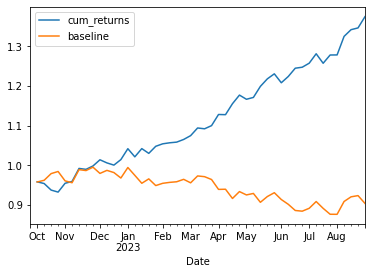

The hit rate for the strategy was 0.417


In [4]:
df["sign"] = np.sign(df["macd_h"])
df["switch"] = ~df["sign"].eq(df["sign"].shift(1))
df["buy/sell"] = np.where(df["switch"] == True, (df["sign"]),np.nan)
df["buy/sell"] = df["buy/sell"].ffill(axis=0)
df["returns"] = df["Close"].pct_change(1)
df
trading_costs = 100 #in bps
number = (1 - trading_costs/10000)
print(number)
df["pnl"] = df["returns"] * df["buy/sell"]
df["cum_returns"] = df["pnl"].cumprod()

df2 = df.copy()
df2 = df2.iloc[20::5,:]
df2["returns"] = df2["Close"].pct_change(1)
df2["pnl"] = df2["returns"] * df2["buy/sell"] * (1 - trading_costs/10000) + 1
df2["cum_returns"] = df2["pnl"].cumprod()
df2["baseline"] = (df2["returns"] + 1).cumprod()

df3 = df2.reset_index()
ax = df3.plot(y=["cum_returns","baseline"],x="Date")
plt.show()
hit_rate = round(np.sign(df2["pnl"] - 1).mean(),3)
print(f'The hit rate for the strategy was {hit_rate}')

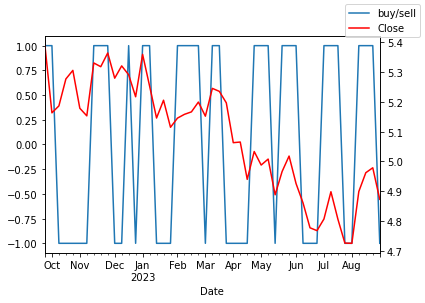

In [5]:

df3 = df2.reset_index()
df2.head()

ax = df3.plot(y="buy/sell", x="Date", legend=False)
ax2 = ax.twinx()
df3.plot(y="Close", ax=ax2, x="Date",legend=False, color="r")
ax.figure.legend()
plt.show()

In [6]:
(df2["pnl"] - 1).mean()

0.0067668683209485435

[*********************100%***********************]  24 of 24 completed


array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>]], dtype=object)

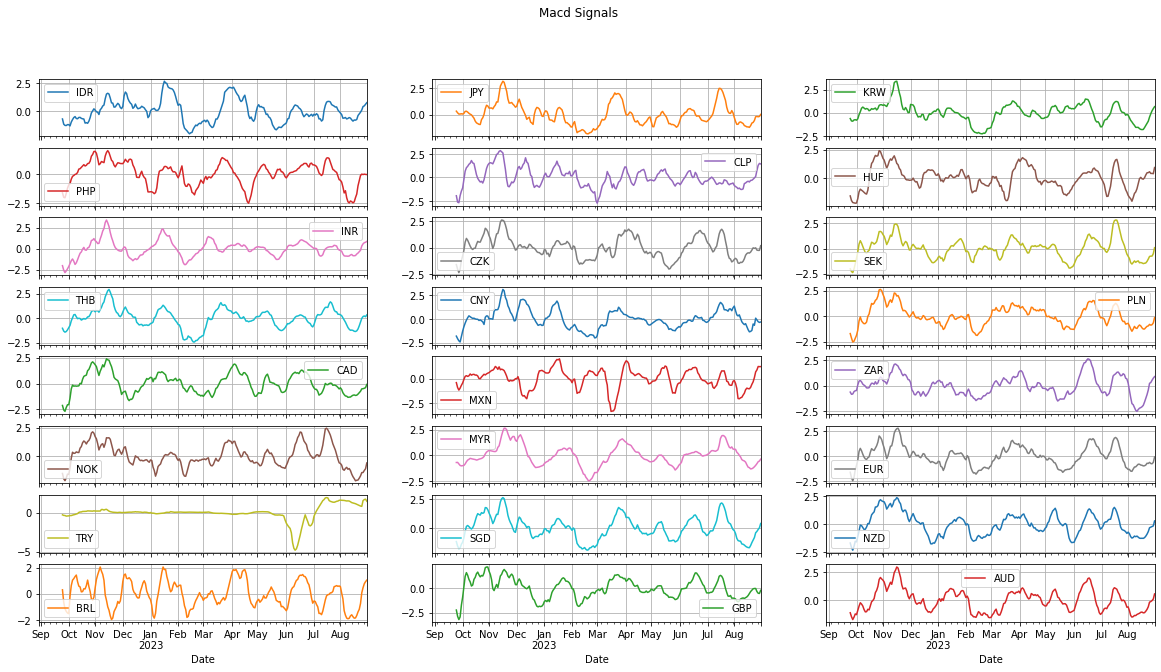

In [7]:
#get all currencies and chart layout of macds

df_ccy = full_df(1)
macd_signals = []
colnames = []
for cols in df_ccy:
    x = calc_macd_cols(df_ccy[cols])
    macd_signals.append(x)
    colnames.append(cols)
df_macd = pd.DataFrame(macd_signals).T
df_macd.columns = colnames
new_list = df_macd.iloc[-1].abs().sort_values().keys().to_list()
df_macd = df_macd[new_list]
norm_macd = (df_macd - df_macd.mean())/df_macd.std()

plt.rcParams["figure.figsize"] = (20,10)
norm_macd.plot(kind='line', subplots=True, grid=True, title="Macd Signals",
        layout=(8,3), sharex=True, sharey=False, legend=True) #, ylim=[-.1,.1])

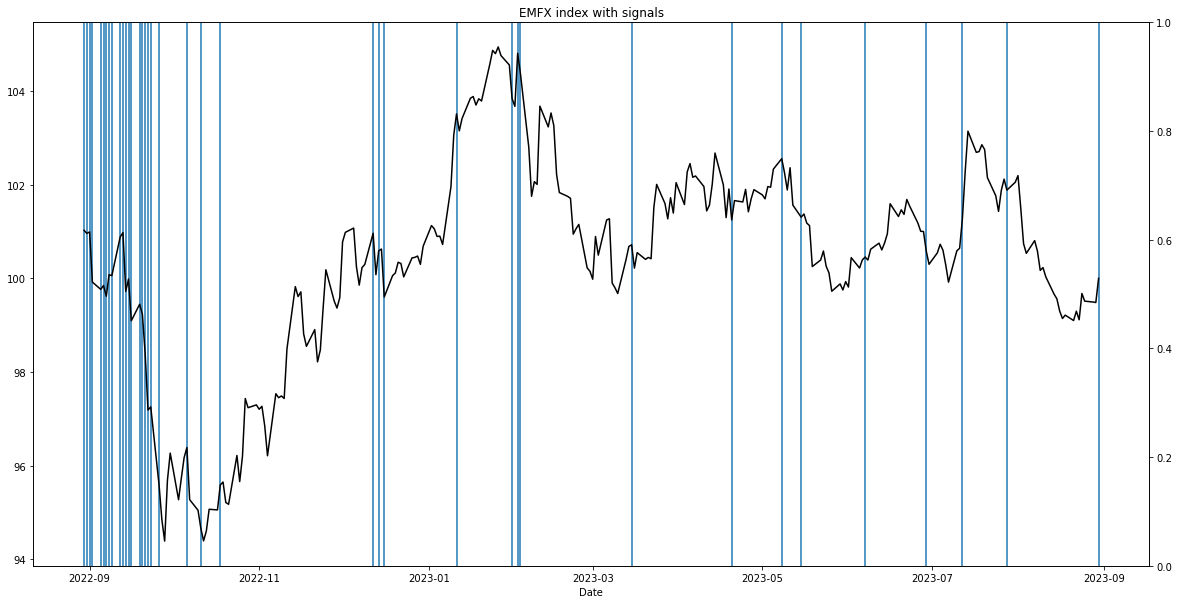

In [8]:
#tried aggregate signal but that one wasnt great
df_index = (df_ccy / df_ccy.iloc[-1] * 100).median(axis=1)
df_macd_median = norm_macd.median(axis="columns").to_frame()
df_macd_median.columns = ["signal"]
df_macd_median["flip"] = np.sign(df_macd_median["signal"]).diff()
df_macd_median["mark"] = np.where(df_macd_median["flip"] != 0,0,1)
vline_list  = df_macd_median[df_macd_median["mark"] == 0].index.tolist()
vline_list

for line in vline_list:
    plt.axvline(x=line)
    
    
sns.lineplot(data=df_index, color="black",legend="auto").set(title='EMFX index with signals')
ax2 = plt.twinx()
#sns.lineplot(data=df_macd_median["signal"], color="green", ax=ax2)

array([[<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
       [<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
        <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>]],
      dtype=object)

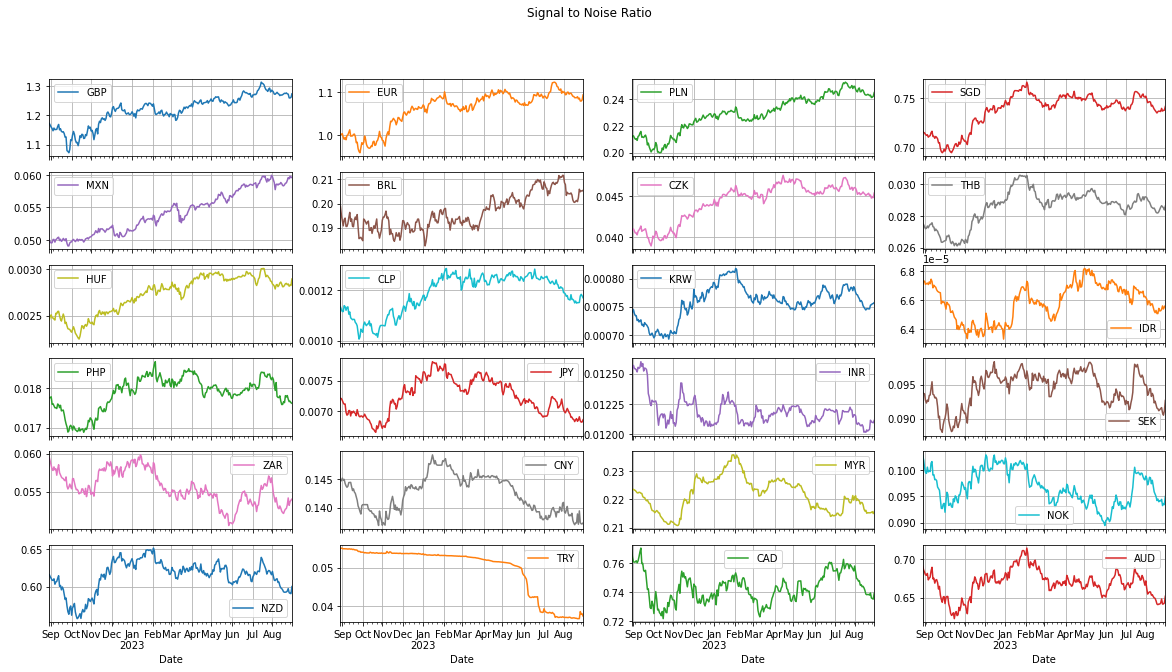

In [9]:
snr_list = []
for cols in df_ccy:
    x = (df_ccy[cols].iloc[-1] - df_ccy[cols].iloc[0])
    y = abs(x) / df_ccy[cols].diff().abs().sum()
    snr_list.append(x)
    
df_snr = pd.DataFrame(snr_list,index=df_ccy.columns,columns=["SNR"])
snr_sort = df_snr.sort_values(by="SNR",ascending=False).index.tolist()
df_ccy[snr_sort].plot(kind='line', subplots=True, grid=True, title="Signal to Noise Ratio",
        layout=(6,4), sharex=True, sharey=False, legend=True)

array([[<AxesSubplot:title={'center':'ZAR'}>,
        <AxesSubplot:title={'center':'JPY'}>,
        <AxesSubplot:title={'center':'NOK'}>,
        <AxesSubplot:title={'center':'TRY'}>],
       [<AxesSubplot:title={'center':'SEK'}>,
        <AxesSubplot:title={'center':'KRW'}>,
        <AxesSubplot:title={'center':'CNY'}>,
        <AxesSubplot:title={'center':'IDR'}>],
       [<AxesSubplot:title={'center':'CAD'}>,
        <AxesSubplot:title={'center':'MYR'}>,
        <AxesSubplot:title={'center':'PHP'}>,
        <AxesSubplot:title={'center':'INR'}>],
       [<AxesSubplot:title={'center':'SGD'}>,
        <AxesSubplot:title={'center':'NZD'}>,
        <AxesSubplot:title={'center':'CZK'}>,
        <AxesSubplot:title={'center':'EUR'}>],
       [<AxesSubplot:title={'center':'BRL'}>,
        <AxesSubplot:title={'center':'GBP'}>,
        <AxesSubplot:title={'center':'THB'}>,
        <AxesSubplot:title={'center':'AUD'}>],
       [<AxesSubplot:title={'center':'PLN'}>,
        <AxesSubplot:title={'

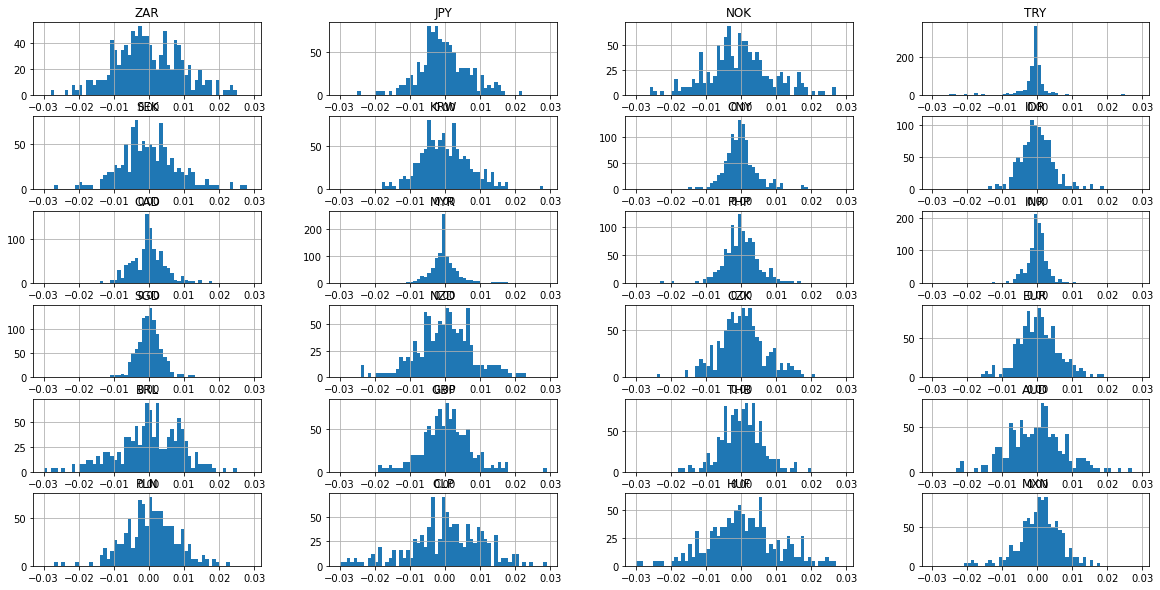

In [10]:
ccy_moves = df_ccy.pct_change(1).median().sort_values(ascending=True).keys().tolist()
df_ccy.pct_change(1).iloc[1:][ccy_moves].hist(sharey=False,grid=True,density=True,stacked=True,
    bins=np.arange(-.03,.03,.001),range=[-.03,.03],layout=(6,4))

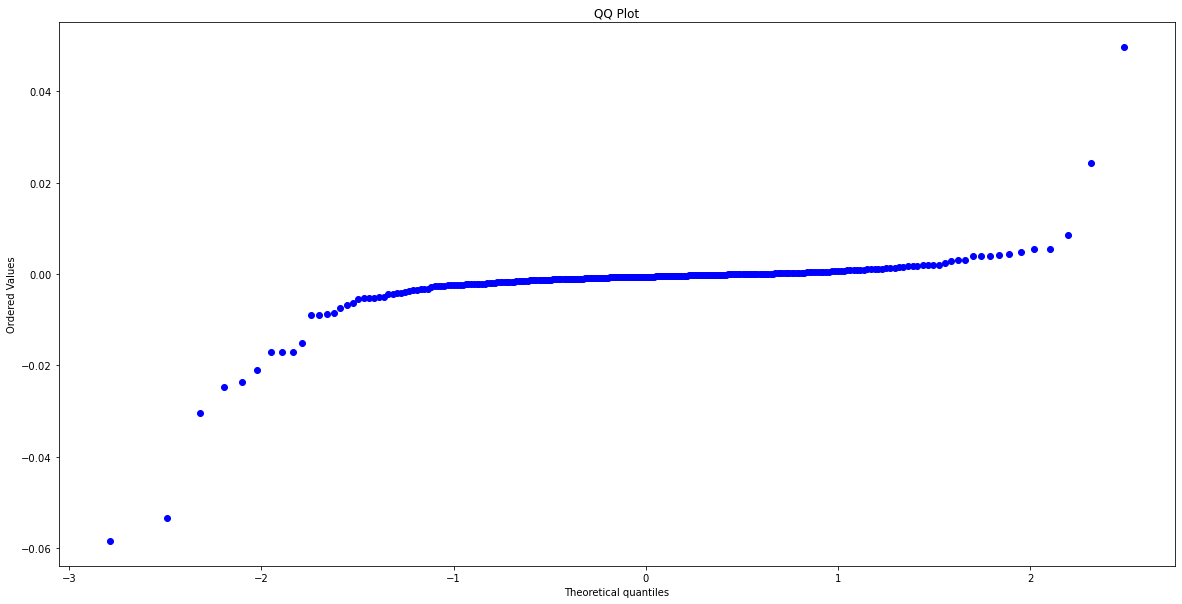

In [11]:
from scipy import stats as scs

model_resid = df_ccy["TRY"].pct_change(1)

scs.probplot(model_resid, dist='norm', plot=plt)
plt.title('QQ Plot')
plt.show()